# Data review and loading data

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, concat
import glob

In [2]:
locn = "C:\\Users\\rangy\\Downloads\\hyddata\\features\\*.txt"
# find all the txt files in the path 
files = glob.glob(locn)
# use a dict to save all the variables 
features = {}

In [4]:
for name in files:
    try:
        with open(name) as f:
            # read in the data 
            temp_df = pd.read_csv(name,delim_whitespace=True,header=None)
            # make the row names cycle as a variable
            temp_df.index.name = 'cycle'
            temp_df.reset_index(inplace=True)
            # transpose the data 
            temp_df_transposed= temp_df.T
            # make the seconds a variable, call it "time”
            temp_df_transposed.index.name = 'time'
            temp_df_transposed.reset_index(inplace=True)
            # add a prefix cycle in the column names to help with pivoting data (from wide to long)
            string = ' cycle'.join(str(e) for e in list(temp_df_transposed.columns))
            temp_df_transposed.columns = string.split(" ")
            # From wide to long to help with joining all the variables 
            temp_df_long = pd.wide_to_long(temp_df_transposed.iloc[1:,:],stubnames='cycle', i=['time'], j='c')
            temp_df_long.reset_index(inplace=True)
            # save each data variable in the long format into separate data frames in the dictionary called "features"
            # but exclude path and txt in the names
            features[name[9:-4]] = temp_df_long
                        
           
    
    # prevent a possible error
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise

In [5]:
label = pd.read_csv("C:\\Users\\rangy\\Downloads\\hyddata\\profile.txt",delim_whitespace=True,header=None)
label.columns = ['cooler_condition', 'valve_condition', 'pump_leak', 'hydraulic_accumulator', 'stable_flag']

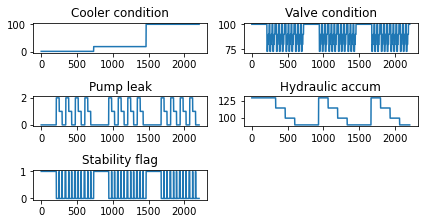

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(4,2,1)
label.cooler_condition.plot() 
plt.title('Cooler condition')

plt.subplot(4,2,2)
label.valve_condition.plot(ax=plt.gca())
plt.title('Valve condition')

plt.subplot(4,2,3)
label.pump_leak.plot(ax=plt.gca())
plt.title('Pump leak')

plt.subplot(4,2,4)
label.hydraulic_accumulator.plot(ax=plt.gca())
plt.title('Hydraulic accum')

plt.subplot(4,2,5)
label.stable_flag.plot(ax=plt.gca())
plt.title('Stability flag')

plt.tight_layout()


# Let's try LSTM on just a feature given the relatively consistent trends above

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [11]:
univar = series_to_supervised(label[['hydraulic_accumulator']],n_in=2,n_out=1)
univar = univar.values

train,test = univar[:1201,:], univar[1202:,:]

xtrain,ytrain = train[:,0:2],train[:,-1]
xtest,ytest = test[:,0:2],test[:,-1]

xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

In [12]:
%pip install keras
%pip install tensorflow
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM

model = Sequential()
model.add(LSTM(60, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(xtrain, ytrain, epochs=50, batch_size=20, validation_data=(xtest, ytest), verbose=0, shuffle=False)

Note: you may need to restart the kernel to use updated packages.



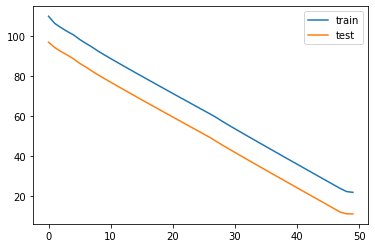

In [13]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [14]:
univar = series_to_supervised(label[['stable_flag']],n_in=2,n_out=1)
univar = univar.values

train,test = univar[:1201,:], univar[1202:,:]

xtrain,ytrain = train[:,0:2],train[:,-1]
xtest,ytest = test[:,0:2],test[:,-1]

xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

model = Sequential()
model.add(LSTM(60, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(xtrain, ytrain, epochs=50, batch_size=20, validation_data=(xtest, ytest), verbose=0, shuffle=False)

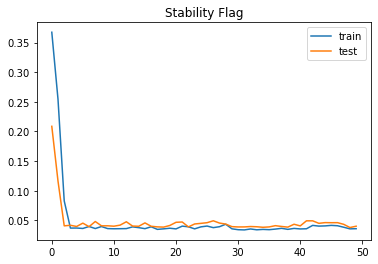

In [17]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Stability Flag')
pyplot.show()


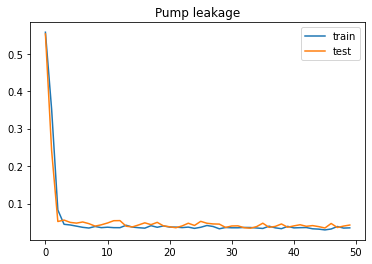

In [18]:
univar = series_to_supervised(label[['pump_leak']],n_in=2,n_out=1)
univar = univar.values

train,test = univar[:1201,:], univar[1202:,:]

xtrain,ytrain = train[:,0:2],train[:,-1]
xtest,ytest = test[:,0:2],test[:,-1]

xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

model = Sequential()
model.add(LSTM(60, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(xtrain, ytrain, epochs=50, batch_size=20, validation_data=(xtest, ytest), verbose=0, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Pump leakage')
pyplot.show()


In [20]:
yhat = model.predict(xtest)
from sklearn.metrics import mean_absolute_error
mean_absolute_error(yhat,ytest)

0.04263332206662837

# Feature Engineering

In [24]:
for key in list(features.keys()):
    features[key].columns=['seconds','cycle',key]

dfs= [features['rangy\\Downloads\\hyddata\\features\\CE'],
      features['rangy\\Downloads\\hyddata\\features\\CP'],
      features['rangy\\Downloads\\hyddata\\features\\EPS1'],
      features['rangy\\Downloads\\hyddata\\features\\FS1'],
      features['rangy\\Downloads\\hyddata\\features\\FS2'],
      features['rangy\\Downloads\\hyddata\\features\\PS1'],
      features['rangy\\Downloads\\hyddata\\features\\PS2'],
      features['rangy\\Downloads\\hyddata\\features\\PS3'],
      features['rangy\\Downloads\\hyddata\\features\\PS4'],
      features['rangy\\Downloads\\hyddata\\features\\PS5'],
      features['rangy\\Downloads\\hyddata\\features\\PS6'],
      features['rangy\\Downloads\\hyddata\\features\\SE'],
      features['rangy\\Downloads\\hyddata\\features\\TS1'],
      features['rangy\\Downloads\\hyddata\\features\\TS2'],
      features['rangy\\Downloads\\hyddata\\features\\TS3'],
      features['rangy\\Downloads\\hyddata\\features\\TS4'],
      features['rangy\\Downloads\\hyddata\\features\\VS1']]

from functools import reduce
features_join = reduce(lambda left,right: pd.merge(left,right,on=['seconds','cycle']), dfs)
features_join.head()

,seconds,cycle,rangy\Downloads\hyddata\features\CE,rangy\Downloads\hyddata\features\CP,rangy\Downloads\hyddata\features\EPS1,rangy\Downloads\hyddata\features\FS1,rangy\Downloads\hyddata\features\FS2,rangy\Downloads\hyddata\features\PS1,rangy\Downloads\hyddata\features\PS2,rangy\Downloads\hyddata\features\PS3,rangy\Downloads\hyddata\features\PS4,rangy\Downloads\hyddata\features\PS5,rangy\Downloads\hyddata\features\PS6,rangy\Downloads\hyddata\features\SE,rangy\Downloads\hyddata\features\TS1,rangy\Downloads\hyddata\features\TS2,rangy\Downloads\hyddata\features\TS3,rangy\Downloads\hyddata\features\TS4,rangy\Downloads\hyddata\features\VS1
0,0,0,47.202,2.184,2411.6,8.990,10.179,151.47,125.50,2.305,0.0,9.936,9.818,68.039,35.570,40.961,38.320,30.363,0.604
1,1,0,47.273,2.184,2411.6,0.770,10.174,151.45,125.39,2.305,0.0,9.947,9.823,0.000,35.492,40.949,38.332,30.375,0.605
2,2,0,47.250,2.184,2411.6,0.641,10.151,151.52,125.40,2.336,0.0,9.964,9.844,0.000,35.469,40.965,38.320,30.367,0.611
3,3,0,47.332,2.185,2411.6,0.006,10.149,151.27,125.03,2.578,0.0,9.989,9.861,0.000,35.422,40.922,38.324,30.367,0.603
4,4,0,47.213,2.178,2411.6,0.000,10.172,150.80,124.05,2.977,0.0,9.996,9.877,0.000,35.414,40.879,38.332,30.379,0.608


In [25]:
%pip install tsfresh
from tsfresh import select_features
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features

# Automatic feautre extraction using the tsfresh package
extracted_features = extract_features(features_join, column_id="cycle", column_sort="seconds")

Note: you may need to restart the kernel to use updated packages.


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 15/15 [11:03<00:00, 44.23s/it]


In [35]:
impute(extracted_features)

C:\Users\rangy\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:171: RuntimeWarning: The columns ['rangy\\Downloads\\hyddata\\features\\CE__fft_coefficient__attr_"real"__coeff_31'
 'rangy\\Downloads\\hyddata\\features\\CE__fft_coefficient__attr_"real"__coeff_32'
 'rangy\\Downloads\\hyddata\\features\\CE__fft_coefficient__attr_"real"__coeff_33'
 ...
 'rangy\\Downloads\\hyddata\\features\\VS1__fft_coefficient__attr_"angle"__coeff_97'
 'rangy\\Downloads\\hyddata\\features\\VS1__fft_coefficient__attr_"angle"__coeff_98'
 'rangy\\Downloads\\hyddata\\features\\VS1__fft_coefficient__attr_"angle"__coeff_99'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


,rangy\Downloads\hyddata\features\CE__variance_larger_than_standard_deviation,rangy\Downloads\hyddata\features\CE__has_duplicate_max,rangy\Downloads\hyddata\features\CE__has_duplicate_min,rangy\Downloads\hyddata\features\CE__has_duplicate,rangy\Downloads\hyddata\features\CE__sum_values,rangy\Downloads\hyddata\features\CE__abs_energy,rangy\Downloads\hyddata\features\CE__mean_abs_change,rangy\Downloads\hyddata\features\CE__mean_change,rangy\Downloads\hyddata\features\CE__mean_second_derivative_central,rangy\Downloads\hyddata\features\CE__median,...,rangy\Downloads\hyddata\features\VS1__fourier_entropy__bins_2,rangy\Downloads\hyddata\features\VS1__fourier_entropy__bins_3,rangy\Downloads\hyddata\features\VS1__fourier_entropy__bins_5,rangy\Downloads\hyddata\features\VS1__fourier_entropy__bins_10,rangy\Downloads\hyddata\features\VS1__fourier_entropy__bins_100,rangy\Downloads\hyddata\features\VS1__permutation_entropy__dimension_3__tau_1,rangy\Downloads\hyddata\features\VS1__permutation_entropy__dimension_4__tau_1,rangy\Downloads\hyddata\features\VS1__permutation_entropy__dimension_5__tau_1,rangy\Downloads\hyddata\features\VS1__permutation_entropy__dimension_6__tau_1,rangy\Downloads\hyddata\features\VS1__permutation_entropy__dimension_7__tau_1
0,1.0,0.0,0.0,1.0,2376.081,96490.454613,0.330644,-0.310780,-0.004241,40.6755,...,0.239217,0.239217,0.424254,0.563420,1.367099,1.686006,2.644019,3.421882,3.711047,3.860623
1,1.0,0.0,0.0,1.0,1547.186,40064.147542,0.229559,-0.095254,0.005638,25.3855,...,0.142506,0.142506,0.457102,0.595073,1.433575,1.595254,2.462080,3.107687,3.498105,3.727584
2,0.0,0.0,0.0,1.0,1333.094,29643.035132,0.181305,-0.034492,0.002319,22.1040,...,0.142506,0.142506,0.379535,0.379535,1.807218,1.664222,2.716036,3.427950,3.760199,3.886296
3,0.0,0.0,0.0,1.0,1227.589,25128.500929,0.196085,-0.019271,-0.000431,20.4805,...,0.142506,0.142506,0.283936,0.595073,1.061467,1.700625,2.632835,3.357998,3.675070,3.850934
4,0.0,0.0,0.0,1.0,1187.221,23496.528969,0.172678,-0.007525,0.001733,19.7985,...,0.142506,0.142506,0.283936,0.424254,1.705525,1.772589,2.863561,3.542382,3.821382,3.963312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.0,0.0,0.0,1.0,2797.711,130456.449601,0.146136,-0.007051,0.002155,46.6335,...,0.142506,0.142506,0.283936,0.424254,1.220532,1.679611,2.719164,3.333242,3.695355,3.860623
2201,0.0,0.0,0.0,1.0,2801.389,130805.448029,0.131864,0.004271,-0.000250,46.6510,...,0.142506,0.283936,0.283936,0.518700,1.192692,1.638909,2.554651,3.198601,3.701534,3.860623
2202,0.0,0.0,0.0,1.0,2788.338,129593.101044,0.129576,-0.004322,0.001940,46.7005,...,0.239217,0.283936,0.283936,0.424254,1.518855,1.708797,2.782633,3.468116,3.805690,3.911968
2203,0.0,1.0,0.0,1.0,2792.698,129989.496364,0.155017,-0.000237,0.000914,46.5490,...,0.239217,0.283936,0.283936,0.283936,1.147973,1.738131,2.780204,3.485050,3.755280,3.911968


# Model evaluation

In [36]:
quadvar_y = label['hydraulic_accumulator']
quadvar_x = extracted_features.values


xtrain_quad,ytrain_quad = quadvar_x[:1201,:], quadvar_y[:1201,]
xtest_quad,ytest_quad = quadvar_x[1202:,:],quadvar_y[1202:,]

xtrain_quad = xtrain_quad.reshape((xtrain_quad.shape[0], 1, xtrain_quad.shape[1]))
xtest_quad = xtest_quad.reshape((xtest_quad.shape[0], 1, xtest_quad.shape[1]))

quadmodel = Sequential()
quadmodel.add(LSTM(60, input_shape=(xtrain_quad.shape[1], xtrain_quad.shape[2])))
quadmodel.add(Dense(5))
quadmodel.add(Dense(1))
quadmodel.compile(loss='mae', optimizer='adam')

In [37]:
 # fit network
quadhistory = quadmodel.fit(xtrain_quad, ytrain_quad, epochs=50, batch_size=20, validation_data=(xtest_quad, ytest_quad), verbose=0, shuffle=False)

In [49]:
quadvar_y = label['pump_leak']

xtrain_quad,ytrain_quad = quadvar_x[:1201,:], quadvar_y[:1201,]
xtest_quad,ytest_quad = quadvar_x[1202:,:],quadvar_y[1202:,]

xtrain_quad = xtrain_quad.reshape((xtrain_quad.shape[0], 1, xtrain_quad.shape[1]))
xtest_quad = xtest_quad.reshape((xtest_quad.shape[0], 1, xtest_quad.shape[1]))

quadmodel = Sequential()
quadmodel.add(LSTM(60, input_shape=(xtrain_quad.shape[1], xtrain_quad.shape[2])))
quadmodel.add(Dense(5))
quadmodel.add(Dense(1))
quadmodel.compile(loss='mae', optimizer='adam')

 # fit network
hist = quadmodel.fit(xtrain_quad, ytrain_quad, epochs=50, batch_size=20, validation_data=(xtest_quad, ytest_quad), verbose=0, shuffle=False)

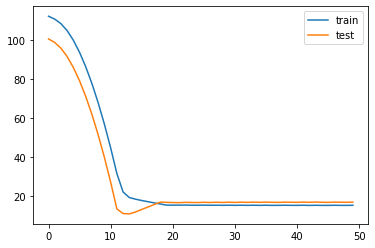

In [40]:
pyplot.plot(quadhistory.history['loss'], label='train')
pyplot.plot(quadhistory.history['val_loss'], label='test')
pyplot.legend()

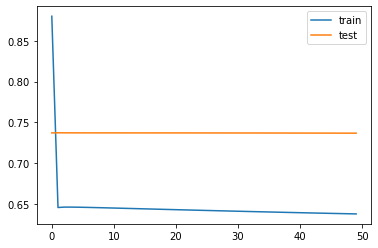

In [50]:
pyplot.plot(hist.history['loss'], label='train')
pyplot.plot(hist.history['val_loss'], label='test')
pyplot.legend()

#  Using feature selection

In [51]:
global features_filtered_accum
features_filtered_accum = select_features(extracted_features, label['hydraulic_accumulator'])
global features_filtered_leak
features_filtered_leak = select_features(extracted_features, label['pump_leak'])

In [52]:
import xgboost
from xgboost import XGBClassifier, XGBRegressor

xgr = XGBRegressor()
xgc = XGBClassifier()

features_filtered_accum = features_filtered_accum.values
label['hydraulic_accumulator'] = label['hydraulic_accumulator'].values

features_filtered_leak = features_filtered_leak.values
label['pump_leak'] = label['pump_leak']

from sklearn.model_selection import KFold, cross_validate
cv = KFold(n_splits=7,shuffle=True)

In [53]:
cross_validate(xgr,features_filtered_accum,label['hydraulic_accumulator'],cv=cv,scoring='neg_mean_absolute_error')

{'fit_time': array([37.76985121, 36.64702988, 36.91531253, 38.0537765 , 37.20354199,
        36.49543571, 36.22416019]),
 'score_time': array([0.01994658, 0.01894975, 0.01795197, 0.01895046, 0.02393699,
        0.01795244, 0.02194142]),
 'test_score': array([-1.07889886, -0.86870471, -0.80623733, -0.89333259, -0.97085215,
        -0.99899105, -1.08738808])}

In [54]:
cross_validate(xgr,features_filtered_leak,label['pump_leak'],cv=cv,scoring='neg_mean_absolute_error')

{'fit_time': array([ 9.27620149,  9.66017461,  8.14322972, 10.287498  , 10.38723183,
        10.76222873, 10.3772583 ]),
 'score_time': array([0.009974  , 0.00997353, 0.01196837, 0.00997376, 0.01097107,
        0.00997496, 0.009974  ]),
 'test_score': array([-0.00576708, -0.0039653 , -0.00576451, -0.00132177, -0.00970895,
        -0.00861044, -0.00350351])}

In [55]:
from tsfresh.transformers import RelevantFeatureAugmenter
from sklearn.pipeline import Pipeline

pipeline_flag = Pipeline([('augmenter', RelevantFeatureAugmenter (column_id="cycle", column_sort="seconds")), ('xgc' , XGBClassifier())])
pipeline_accum = Pipeline([('augmenter', RelevantFeatureAugmenter (column_id="cycle", column_sort="seconds")), ('xgr', XGBRegressor())])

y_stable_flag = label['stable_flag']
y_hydraulic_accumulator = label['hydraulic_accumulator']

X = pd.DataFrame(index = y_stable_flag.index)

pipeline_flag.set_params(augmenter__timeseries_container=features_join)
pipeline_accum.set_params(augmenter__timeseries_container=features_join)

pipeline_flag.fit(X,y_stable_flag)
pipeline_accum.fit(X,y_hydraulic_accumulator)

import pickle
pickle.dump(pipeline_accum,open('pipeline_accum.pkl','wb'))
pickle.dump(pipeline_flag,open('pipeline_flag.pkl','wb'))

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 15/15 [11:06<00:00, 44.41s/it]
C:\Users\rangy\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:171: RuntimeWarning: The columns ['rangy\\Downloads\\hyddata\\features\\CE__fft_coefficient__attr_"real"__coeff_31'
 'rangy\\Downloads\\hyddata\\features\\CE__fft_coefficient__attr_"real"__coeff_32'
 'rangy\\Downloads\\hyddata\\features\\CE__fft_coefficient__attr_"real"__coeff_33'
 ...
 'rangy\\Downloads\\hyddata\\features\\VS1__fft_coefficient__attr_"angle"__coeff_97'
 'rangy\\Downloads\\hyddata\\features\\VS1__fft_coefficient__attr_"angle"__coeff_98'
 'rangy\\Downloads\\hyddata\\features\\VS1__fft_coefficient__attr_"angle"__coeff_99'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
C:\Users\rangy\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in 

[11:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 15/15 [10:58<00:00, 43.87s/it]
C:\Users\rangy\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:171: RuntimeWarning: The columns ['rangy\\Downloads\\hyddata\\features\\CE__fft_coefficient__attr_"real"__coeff_31'
 'rangy\\Downloads\\hyddata\\features\\CE__fft_coefficient__attr_"real"__coeff_32'
 'rangy\\Downloads\\hyddata\\features\\CE__fft_coefficient__attr_"real"__coeff_33'
 ...
 'rangy\\Downloads\\hyddata\\features\\VS1__fft_coefficient__attr_"angle"__coeff_97'
 'rangy\\Downloads\\hyddata\\features\\VS1__fft_coefficient__attr_"angle"__coeff_98'
 'rangy\\Downloads\\hyddata\\features\\VS1__fft_coefficient__attr_"angle"__coeff_99'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
